#  Radial undersampling experiments realised for the in-silico study

In [ ]:
import json
import sys
import os
from joblib import Parallel, delayed
import numpy as np
from time import time
import pynufft

sys.path.append(os.path.join(os.getcwd(), os.pardir))

from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights
from Tools.reconstruction_utils import NN_prediction
from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks_new import initialize_network
import function_reconstruction_radial

2025-02-12 15:43:51.758843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 15:43:51.779406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 15:43:51.785764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 15:43:51.803163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 15:43:52.624773: W tensorflow/compiler/tf2

## Data loading

In [ ]:
#Path to summer and to data
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

#Load brain ROI
roi_brain_filepath = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424/ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219"
path_to_ROI_brain_map = os.path.join(path_to_summer_current, roi_brain_filepath)
ROI_brain, _, _ =  load_acquisition_reconstruction_from_nii(path_to_ROI_brain_map, nb_indents=1, v=False)

#Load k-space from FS cartesian data
Philips_raw_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240424_FS_ksp_full.npy")
k_space = np.load(Philips_raw_filepath)

#Load coil sensitivity
sens = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240424_sens.npy")
sensitivity_map = np.load(sens)

#Load Philips reconstruction
Philips_reco_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/reco_FS.npy")
RECO = np.load(Philips_reco_filepath)

#Load Philips spiral trajectory
traj_spirale_filepath = os.path.join(path_to_summer_current, "2023_MRF_Collab/Antoine/RAW_DATA_FS/20240410_traj_spirale_philips.npy")
traj_spirale = np.load(traj_spirale_filepath)
traj_spirale = traj_spirale[0:2,:]*np.pi / np.max(traj_spirale[0:2,:])

## Obtain image from the FS k-space and crop data to obtain 192x192 images

In [ ]:
image = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(k_space, axes = (3,4)), axes = (3,4)), axes = (3,4))

start_index = int(k_space.shape[4] / 4)
end_index = int(k_space.shape[4] * 3 / 4)

image = image[:,:,:,:, start_index:end_index:1]

In [ ]:
sensitivity_map_crop = sensitivity_map[:,:,start_index:end_index]

In [ ]:
for spoke in [1,2,3,4,5,6,7,8,9,10,11,12,16,20,24,48,96,192]: 
    traj, cg_sense  = function_reconstruction_radial.radial_reconstruction(image=image, k_space=None, trajectory=None, sensitivity_map=sensitivity_map_crop, n_iters=60, nspoke = spoke, rotationGA_spoke=False, radial_rotation=True, return_trajectory=True)
    file_name = 'reco_cg_sense_'+ str(spoke) +'spokes'
    path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/tests_cg_sense/reco_acquisitions/reco_cg_sense/turning_spokes/uniform_spoke_distrib', file_name)
    np.save(path,cg_sense)

# Compare to SOS reconstruction

In [13]:

def process_nufft(pulse, image, radial_trajectory, n_spokes, radial_rotation):
    if radial_rotation is True :
        theta = pulse * 111.25
    else:
        theta = 0
    
    conc_trajectory = function_reconstruction_radial.generate_radiale_traj(radial_trajectory.T,theta)
    
    om = conc_trajectory
    
    Nd = (192, 192)
    Kd = (384, 384)
    Jd = (6, 6)

    y_nufft_coils = np.zeros((31,192,192), dtype=complex)


    obj_nufft = pynufft.NUFFT()
    obj_nufft.plan(om, Nd, Kd, Jd)

    for coil in range (31):
        k_space_nufft = obj_nufft.forward(image[coil, pulse, 0, :, :])
        y_nufft = obj_nufft.solve(k_space_nufft, solver='cg', maxiter=60)
        y_nufft_coils[coil,:,:] = y_nufft
    
    return pulse, y_nufft_coils

def parallel_process(image, nspoke, trajectory, radial_rotation):
    y_nufft_sum = np.zeros_like(image)  
    
    results = Parallel(n_jobs=-1)(delayed(process_nufft)(pulse, image, trajectory, nspoke, radial_rotation = radial_rotation) for pulse in range(260))  
                                  
    for pulse, nufft in results:
        y_nufft_sum[:,pulse, 0,:,:] = nufft
    
    return y_nufft_sum

In [ ]:
all_reco = []
for nspoke in [1,3,5,7,9,11,13,15,19,23,47,95,191]:
    trajectory = function_reconstruction_radial.radial_sigpy((nspoke,192,2), (192, 192), golden=False, half_spoke = False)
    trajectory = trajectory*np.pi / np.max(trajectory)
    trajectory = np.transpose(trajectory, (2,1,0)).reshape(2,-1)

    y_nufft_sum = parallel_process(image, nspoke, trajectory, radial_rotation=True)
    all_reco.append(y_nufft_sum)

all_reco_sos = [np.sqrt(np.sum(np.abs(reco)**2, axis=(0))) for reco in all_reco]
file_name = 'reco_sos'
path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/tests_cg_sense/reco_acquisitions/reco_sos/turning_spokes/uniform_spoke_distrib', file_name)
np.save(path,all_reco_sos)

2025-02-12 17:03:49.801967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 17:03:49.805316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 17:03:49.826440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 17:03:49.831460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 17:03:49.832708: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory

## MARVEL reconstructions

In [ ]:
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/DICO8/train_updated_code_v2_LR0.9')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [ ]:
n_pulses = 260
n_epochs = 87

start = time()
print("\nINITIALIZE NETWORK")
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)

network_name = "BiLSTM"
input_size = n_pulses 
print(input_size)
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))

NN.summary()


INITIALIZE NETWORK
260
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 260, 1)            0         
                                                                 
 bidirectional (Bidirection  (None, 100)               20800     
 al)                                                             
                                                                 
 dense (Dense)               (None, 75)                7575      
                                                                 
 dense_1 (Dense)             (None, 50)                3800      
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 32481 (126.88 KB)
Trainable params: 32481 (126.88 KB)
Non-trainable params: 0 (0.00 

In [ ]:
#Convert data to the correct format
cg_sense_array = cg_sense.numpy()
cg_sense_array =np.transpose(cg_sense_array, (1,2,0))
cg_sense_array = np.expand_dims(cg_sense_array, 2)

ROI_brain_map_rot = np.rot90(ROI_brain ==1)
if ROI_brain_map_rot.ndim == 2:
    ROI_brain_map_rot = ROI_brain_map_rot[:, :, None]


In [ ]:
label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']

#Rotation and normalization

RECO_rot = np.rot90(RECO)
RECO_norm = np.abs(RECO_rot)/np.maximum(np.linalg.norm(np.abs(RECO_rot), axis=3)[:, :, :, None], 1e-10)

CG_reconstruction_rot = np.rot90(cg_sense_array,-1)

CG_reconstruction_norm = np.abs(CG_reconstruction_rot)/np.maximum(np.linalg.norm(np.abs(CG_reconstruction_rot), axis=3)[:, :, :, None], 1e-10)

#Predictions

NN_reconstruction_RECO = NN_prediction(NN, RECO_norm, label_parameters, ROI_brain_map_rot, batch_size=1024)
NN_reconstruction_CG = NN_prediction(NN, CG_reconstruction_norm, label_parameters, ROI_brain_map_rot, batch_size=1024)

14/14 [==============================] - 2s 157ms/step


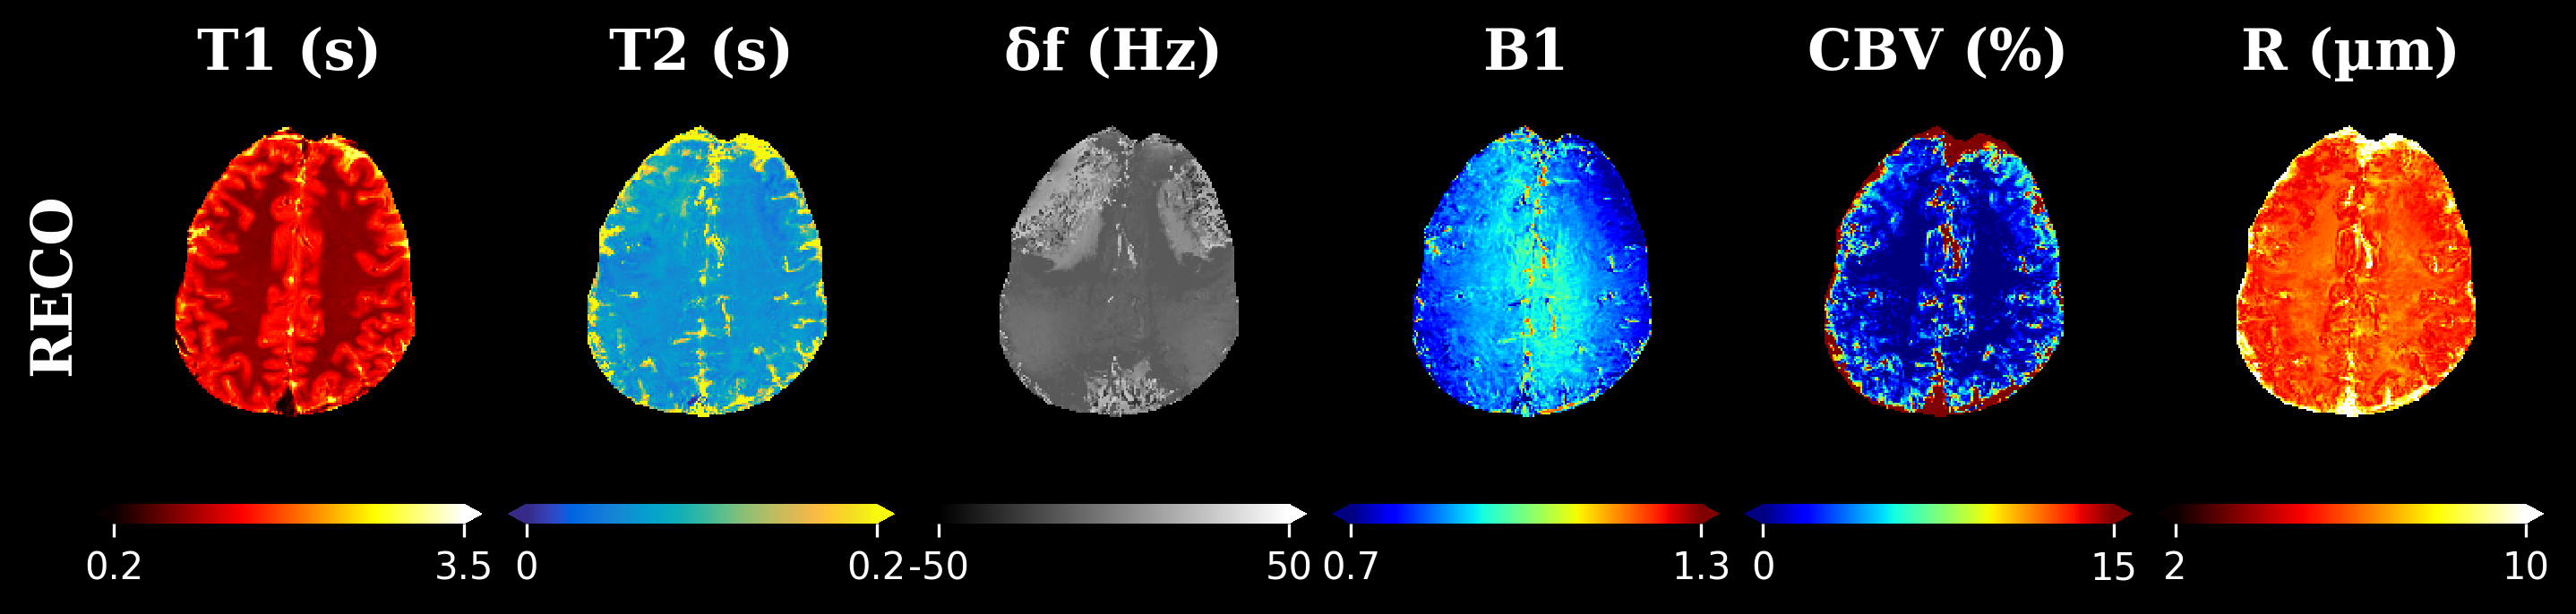

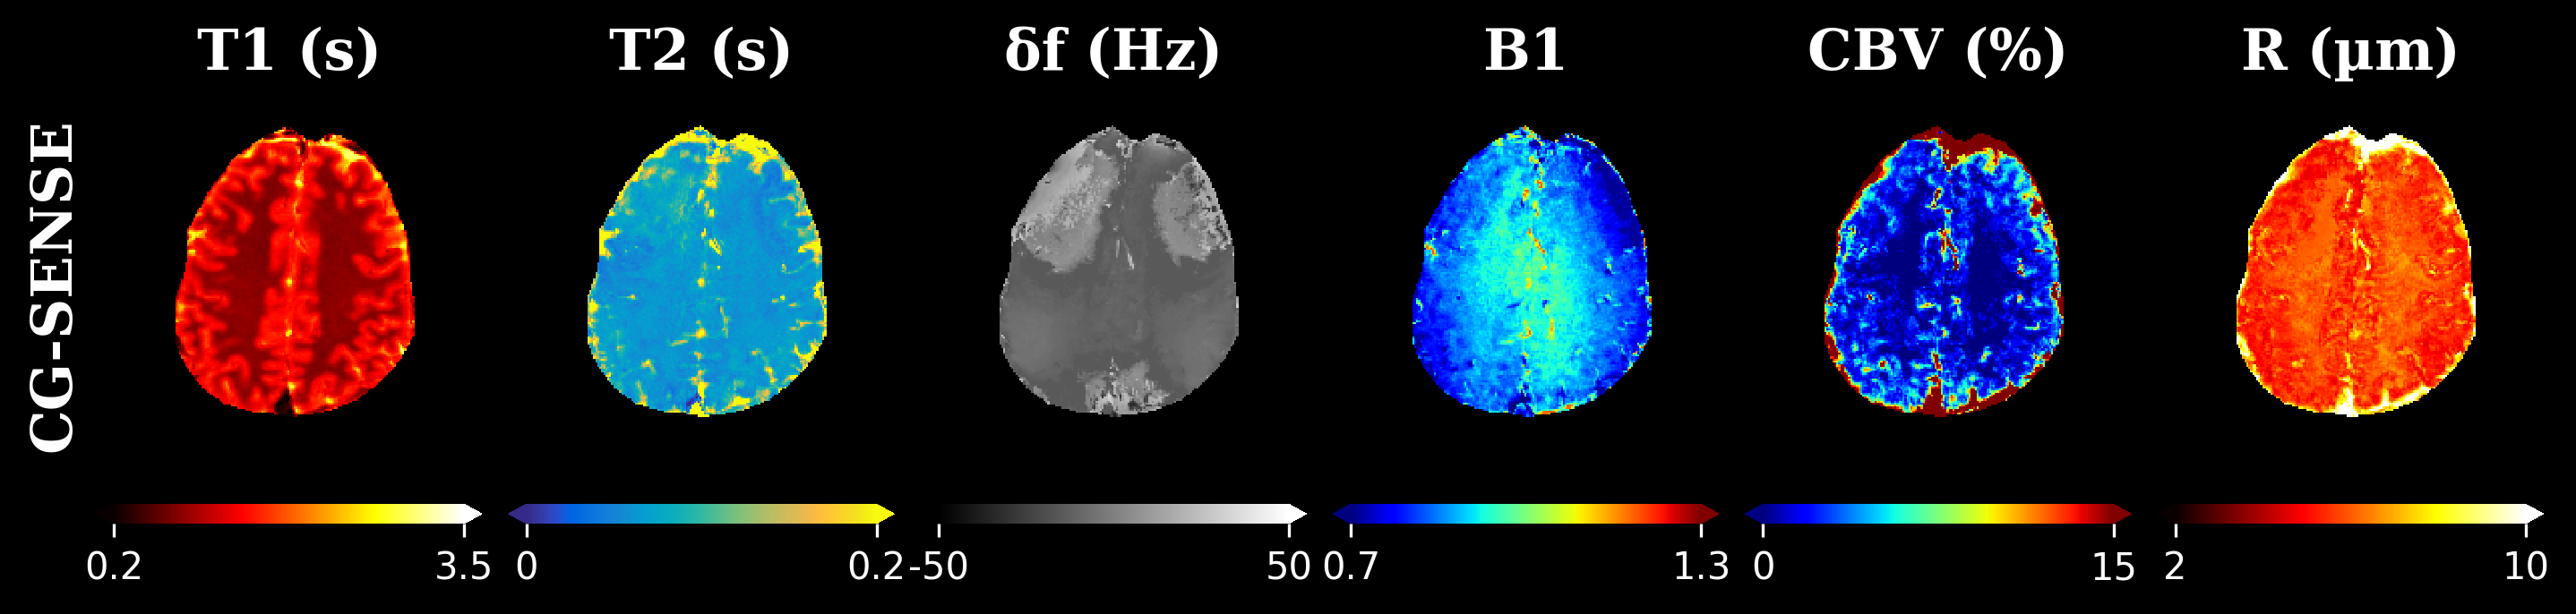

In [ ]:
#Plot MARVEL outputs

fig = plot_parameter_maps(NN_reconstruction_RECO, label_parameters, title='', slice_titles = ['RECO'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))
fig = plot_parameter_maps(NN_reconstruction_CG, label_parameters, title='', slice_titles = ['CG-SENSE'],path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))